In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./data/train.csv')
data.head(10)

,Id,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,Category
0,120,0.147298,-0.142030,0.091737,-0.151707,0.060124,0.186191,-0.021298,-0.025636,0.061044,...,-0.218118,0.011316,0.079464,-0.010833,-0.053485,0.046450,-0.008333,0.168574,0.123273,0
1,121,0.115710,0.105061,0.038446,0.166711,-0.113913,0.004528,-0.006954,-0.140054,0.154231,...,0.021526,0.069009,-0.060343,0.094007,0.049558,0.112370,0.020398,0.039687,0.217384,0
2,122,-0.548826,-0.466551,-0.650890,-0.553450,-0.449101,-0.496902,-0.464860,-0.394458,-0.271801,...,0.057272,0.088062,-0.069730,0.168498,0.109672,0.202808,-0.019942,0.058902,0.053936,0
3,123,0.192618,0.291155,-0.042980,0.146483,0.015390,0.019394,-0.005577,-0.048682,0.025772,...,0.140831,0.257332,0.262786,0.351659,0.213291,0.251077,0.190920,0.251743,0.337730,1
4,124,0.075706,0.069045,-0.019818,0.068801,-0.226501,0.011658,0.087905,-0.080787,-0.080369,...,0.434803,0.322841,0.297772,0.461421,0.406143,0.562082,0.554588,0.471489,0.384229,1
5,125,1.081769,0.986722,1.067524,1.140523,0.975286,1.074729,0.871820,1.140957,1.276274,...,2.098946,1.882913,1.979897,1.852567,2.043995,2.059601,2.219500,2.038103,2.072409,1
6,126,0.212677,0.271821,0.052499,0.353935,0.177247,0.165208,0.077037,0.054077,0.001218,...,0.880501,0.894316,0.776692,0.910526,1.145064,1.302965,1.182394,1.286594,1.184424,1
7,127,-1.044003,-0.994305,-0.885585,-0.678902,-0.717464,-0.513387,-0.501884,-0.647595,-0.336069,...,0.607999,0.508485,0.442513,0.644257,0.838618,0.936488,0.929766,0.965134,1.024578,1
8,128,0.984083,0.938459,0.956299,0.922269,1.078399,1.107597,0.983515,1.222726,1.049279,...,1.937170,1.951902,2.069157,2.075734,1.953834,1.922141,1.913410,1.965790,1.956595,0
9,129,-0.056781,0.053274,0.033048,0.010449,0.101132,-0.055987,-0.045404,0.012941,-0.047868,...,0.231157,0.182868,0.240331,0.156288,0.218797,0.042883,0.127180,0.130278,0.162561,0


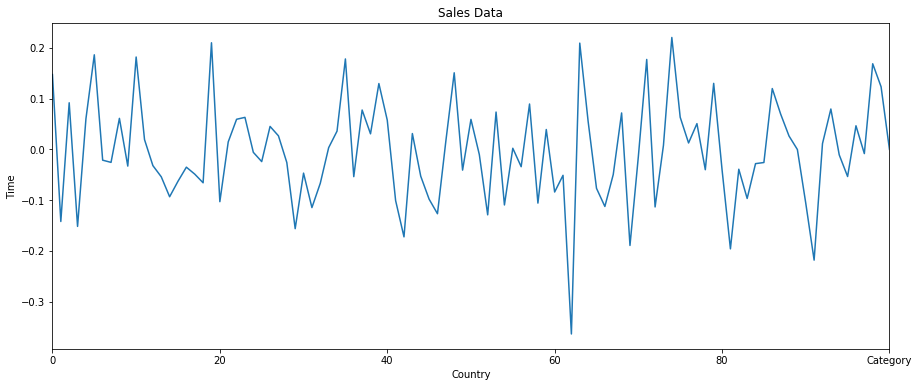

In [3]:
ax = data.iloc[0, data.columns != 'Id'].plot(figsize = (15,6), title="Sales Data", legend = False)
ax.set(xlabel="Country", ylabel="Time")
plt.show()

# Test out on a single country

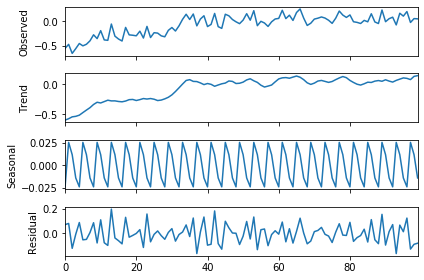

In [26]:
country_id = 2

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data.iloc[country_id,1:101], model='additive', freq=4, extrapolate_trend='freq')
result.plot()
plt.show()

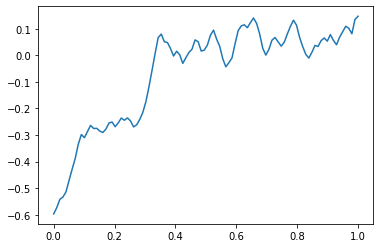

In [27]:
X = np.linspace(0,1,100)
Y = result.trend.values
X = X[:, None]
Y = Y[:, None]
plt.plot(X,Y)

Optimization restart 1/5, f = -224.5126150039734
Optimization restart 2/5, f = -224.51260985044934
Optimization restart 3/5, f = -224.51260280128542
Optimization restart 4/5, f = -224.5126132825028
Optimization restart 5/5, f = -224.5126145874545


GP_regression.,value,constraints,priors
sum.Mat52.variance,0.03892069160910272,+ve,
sum.Mat52.lengthscale,0.06321632069683562,+ve,
sum.linear.variances,1.0786127388268446e-11,+ve,
Gaussian_noise.variance,6.485884910868315e-05,+ve,


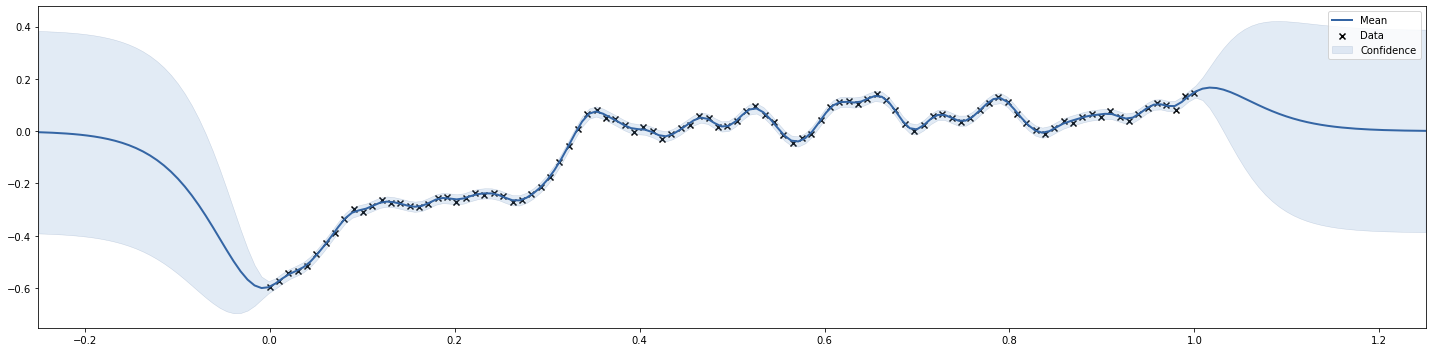

In [28]:
import GPy as GPy

ker1 = GPy.kern.Matern52(1)
ker2 = GPy.kern.Linear(1)

kernel = ker1+ker2

# create a GP model
g_model = GPy.models.GPRegression(X,Y,kernel=kernel)

# it finds the optimal parameters of the RBF kernel by maxisiming the marginal likelihood 
g_model.optimize_restarts(5)# this maximise the marginal likelihood, with random restarts
#we  plot it
fig = g_model.plot(figsize=(20,5))
display(g_model)

Looks good?

# Lets try on the training set

In [29]:
def run_model(x_in, y_in):
    import GPy as GPy

    ker1 = GPy.kern.Matern52(1)
    ker2 = GPy.kern.Linear(1)
    kernel = ker1+ker2

    g_model = GPy.models.GPRegression(x_in,y_in,kernel=kernel)

    g_model.optimize_restarts(5, robust=True, verbose=False, parallel=True, num_processes=12)
    
    X_test = x_in
    X_test = X_test.reshape(-1,1)
    
    f_pred, sigm_pred = g_model.predict(X_test, kern=kernel)
        
    plt.title('Prediction Plot')
    plt.plot(x_in[:,0],f_pred)
    plt.show()
    
    kernel.plot()
    plt.show()
    
    posterior_probability_deriviative_is_positive = len(np.where(np.gradient(f_pred[:,0],X_test[:,0])>0)[0])/len(f_pred[:,0])
    
    #print("Probability Sales Increasing is: ", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.8:
        return 1
    else:
        return 0

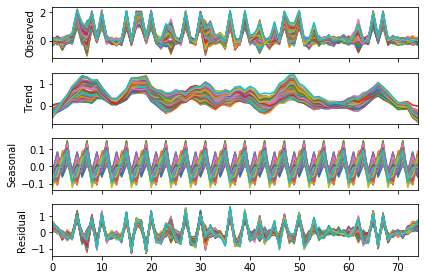

In [30]:
sd = seasonal_decompose(data.iloc[:,1:101], model='additive', freq=4, extrapolate_trend='freq')
sd.plot()
plt.show()

non_seasonal = sd.trend

In [31]:
rows = non_seasonal.shape[0] - 70
actual = data.head(rows)['Category']

print(non_seasonal.shape)
print(rows)
print(actual.shape[0])

(75, 100)
5
5


Iteration: 0 of 5


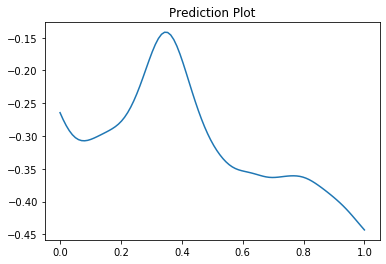

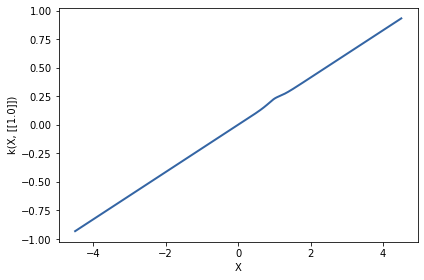

Iteration: 1 of 5


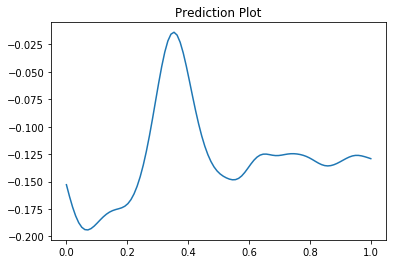

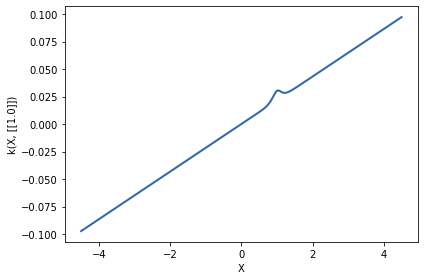

Iteration: 2 of 5


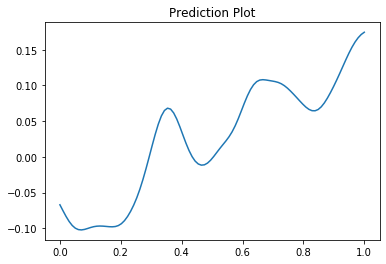

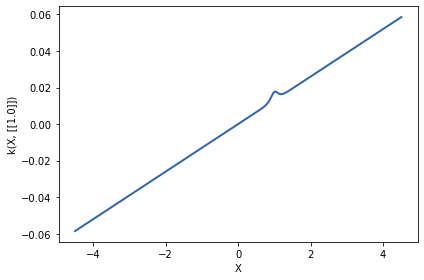

Iteration: 3 of 5


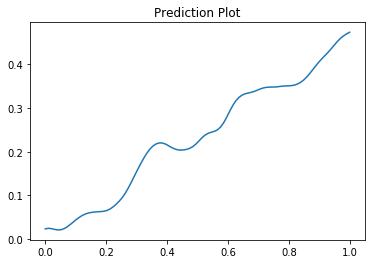

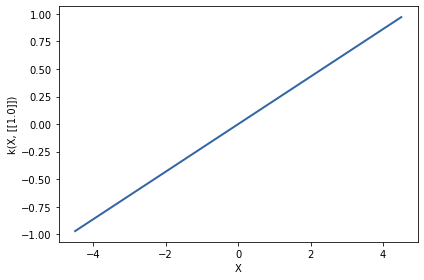

Iteration: 4 of 5


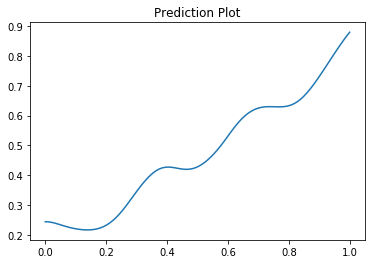

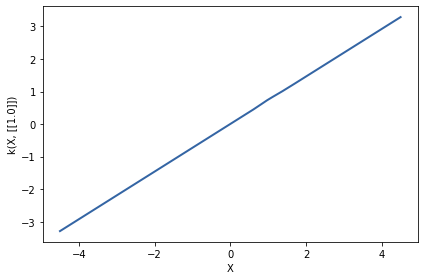

In [32]:
x = np.linspace(0,1,100).reshape(-1,1)
predicted = []
for r in range(rows):
    print(f'Iteration: {r} of {rows}')
    id_row = data.iloc[r,0]
    y = non_seasonal.iloc[r,0:100].values[:,None]
    decision = run_model(x,y)
    predicted.append(decision)

In [33]:
print(predicted)

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

results = confusion_matrix(actual, predicted) 
print(results)
print('Accuracy Score :', accuracy_score(actual, predicted))
print ('The Report : ')
print (classification_report(actual, predicted))

[0, 0, 0, 1, 0]
[[3 0]
 [1 1]]
Accuracy Score : 0.8
The Report : 
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5

